# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [35]:
# Load the libraries as required.
%load_ext dotenv
%dotenv 

import os
import sys
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.naive_bayes import GaussianNB

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [37]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [38]:
X = fires_dt.drop(columns = 'area')
Y = fires_dt['area']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [54]:
#pipeline set up..
#separate teh numeric and categorical features
#using .info() above.. looks like teh only categorical info is month and day

numeric_cols = ['coord_x', 
                'coord_y',
                'ffmc', 
                'dmc', 
                'dc', 
                'isi', 
                'temp', 
                'rh', 
                'wind', 
                'rain']
categorical_cols = ['month', 'day']


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [88]:
#initiate pipeline 1
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy = 'median'))
])

preproc1 = ColumnTransformer([
    ('numeric', pipe1, numeric_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [89]:
pipe2 = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy = 'median'))
])

preproc2 = ColumnTransformer([
    ('numeric', pipe2, numeric_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [ ]:
#import the lasso - baseline and random forest regressor- advanced models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [90]:
# Pipeline A = preproc1 + baseline
PipelineA = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Lasso(random_state=0))
])
PipelineA


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso(random_state=0))])

In [91]:
# Pipeline B = preproc2 + baseline
PipelineB = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Lasso(random_state=0))
])
PipelineB


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso(random_state=0))])

In [92]:
# Pipeline C = preproc1 + advanced model
PipelineC = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42, 
                                        n_jobs=-1)) #use all cores on the computer
])
PipelineC

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [93]:
# Pipeline D = preproc2 + advanced model
PipelineD = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42, 
                                        n_jobs=-1)) # use all cores on the computer
])
PipelineD

    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [ ]:
#set up the regression scoring params
#note.. these are different than classification scores
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#split the data into 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#set up the lasso param_grid
param_grid_lasso = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
    'regressor__max_iter': [1000, 2500,5000]}

#set up the random forest param grid
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [1, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

In [ ]:

#test to see if pipelineA runs..
grid_cv_lassoA = GridSearchCV(
estimator=PipelineA, 
param_grid=param_grid_lasso, 
scoring = scoring, 
cv = 5,
refit = "neg_mean_squared_error")
grid_cv_lassoA.fit(X_train, Y_train)

#works..


/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+04, tolerance: 7.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+05, tolerance: 8.391e+01
  model = cd_fast.enet_coordinate_descent(
/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Lasso(random_state=0))]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
                         'regressor__max_iter': [1000, 2500, 5000]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [ ]:
# do gridsearch on the remaining B-D pipelines
grid_cv_lassoB= GridSearchCV(
estimator=PipelineB, 
param_grid=param_grid_lasso, 
scoring = scoring, 
cv = 5,
refit = "neg_mean_squared_error")
grid_cv_lassoB.fit(X_train, Y_train)

/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+03, tolerance: 8.391e+01
  model = cd_fast.enet_coordinate_descent(
/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+03, tolerance: 7.991e+01
  model = cd_fast.enet_coordinate_descent(
/Users/adamhealey/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('transform',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Lasso(random_state=0))]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
                         'regressor__max_iter': [1000, 2500, 5000]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [96]:
grid_cv_rfC= GridSearchCV(
estimator=PipelineC, 
param_grid=param_grid_rf, 
scoring = scoring, 
cv = 5,
refit = "neg_mean_squared_error")
grid_cv_rfC.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'regressor__max_depth': [1, 5, 10, 20],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [97]:

grid_cv_rfD= GridSearchCV(
estimator=PipelineD, 
param_grid=param_grid_rf, 
scoring = scoring, 
cv = 5,
refit = "neg_mean_squared_error")
grid_cv_rfD.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('transform',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'regressor__max_depth': [1, 5, 10, 20],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'])

In [ ]:
#best Params per pipeline
print("PipelineA Best Params:", grid_cv_lassoA.best_params_)
print("PipelineB Best Params:", grid_cv_lassoB.best_params_)
print("PipelineC Best Params:", grid_cv_rfC.best_params_)
print("PipelineD Best Params:", grid_cv_rfD.best_params_)

#best scores: - mean sq error
print("PipelineA Best MSE:", -grid_cv_lassoA.best_score_)
print("PipelineB Best MSE:", -grid_cv_lassoB.best_score_)
print("PipelineC Best MSE:", -grid_cv_rfC.best_score_)
print("PipelineD Best MSE:", -grid_cv_rfD.best_score_)

PipelineA Best Params: {'regressor__alpha': 1.0, 'regressor__max_iter': 1000}
PipelineB Best Params: {'regressor__alpha': 1.0, 'regressor__max_iter': 1000}
PipelineC Best Params: {'regressor__max_depth': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
PipelineD Best Params: {'regressor__max_depth': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
PipelineA Best MSE: 2091.4518986780536
PipelineB Best MSE: 2082.7222550629886
PipelineC Best MSE: 2150.9715383536545
PipelineD Best MSE: 2147.4400296350386


# Evaluate

+ Which model has the best performance?
>>> Surprisingly (according to mean sq error values), Pipeline B - Lasso + transformation had the best performance

# Export

+ Save the best performing model to a pickle file.

In [116]:
import pickle

# Extract the best parameters
best_params = grid_cv_lassoB.best_params_

# Save them to a pickle file
with open("best_lasso_pipelineB_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

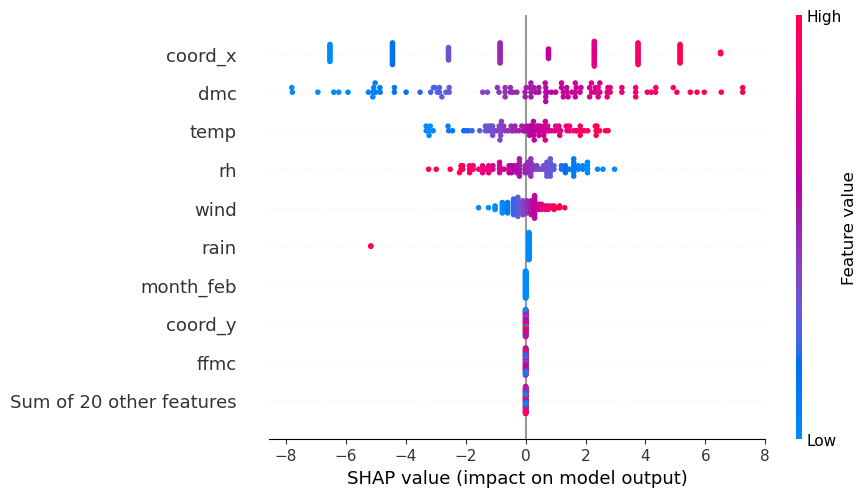

In [ ]:
import shap

#Get the best model from GridSearchCV
best_model = grid_cv_lassoB.best_estimator_

#access the individual step 'preprocessing'
X_transform = best_model.named_steps['preprocessing'].transform(X_test)

#Get feature names
# Numeric features
numeric_features = numeric_cols
# Cat features after OneHotEncoding
categorical_features = best_model.named_steps['preprocessing']\
                        .named_transformers_['categorical']\
                        .get_feature_names_out(categorical_cols)
#Combine
feature_names = list(numeric_features) + list(categorical_features)

#Use SHAP Linear Explainer
#remember, I can use the linear explainer because lasso is a linear regression
explainer = shap.LinearExplainer(best_model.named_steps['regressor'], X_transform)

# calc SHAP values
shap_values = explainer(X_transform)

#Visualize
shap_values.feature_names = feature_names
shap.plots.beeswarm(shap_values,show=True)

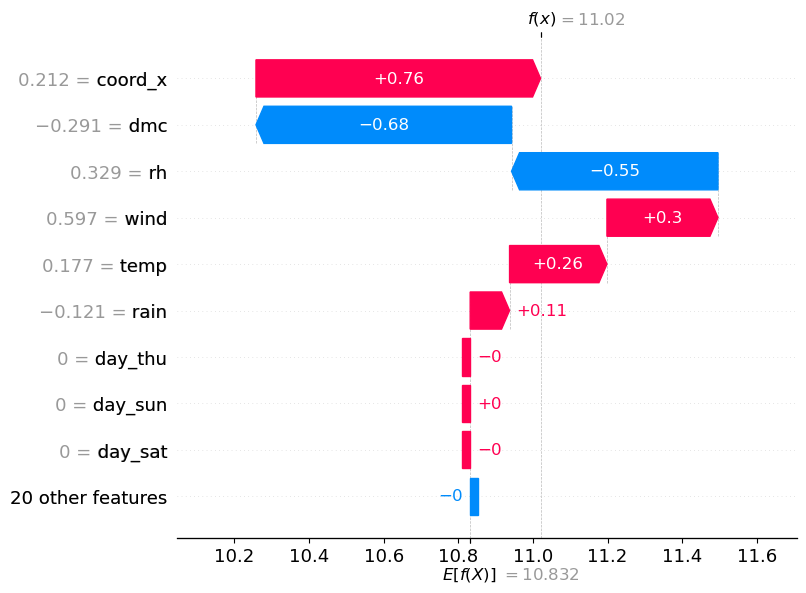

In [128]:
shap.plots.waterfall(shap_values[3])

Generally, the features that are most important for the model are:
* coord_x
* dmc
* rh
* wind
* temp

Least important are:
* month
* day
* coord_y
* ffmc

For the feature I selected (shap_values[3]) the most important features are:
* coord_x - East/West coordinates increase prediction
* dmc - duff moisture code decreases the prediction
* rh - relative humidity decreases the prediction
* wind/temp - both wind and temp increase the prediction

If I were to remove features from the model I would remove the least important ones (month, day, ffmc, etc..) as they did not contribute to the model performance.. But I also dont think this model performed particularly well (lasso outperformed RF), so it would be better to find the best model first, and then start removing features.  I would then re-test against the previous full model to see how it improved using the same criteria used to evaluate models above.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.